<a href="https://colab.research.google.com/github/kannursaya/InDrive-Solution-427/blob/main/inDriveSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# ---------------------------
# Haversine distance (в км)
# ---------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # радиус Земли в км
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)

    a = sin(dphi/2)**2 + cos(phi1) * cos(phi2) * sin(dlambda/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# ---------------------------
# Вычисление признаков для маршрута
# ---------------------------
def extract_features(df):
    route_length = 0
    est_time = 0
    stops = 0

    # считаем длину и время по сегментам
    for i in range(1, len(df)):
        d = haversine(df.iloc[i-1].lat, df.iloc[i-1].lng,
                      df.iloc[i].lat, df.iloc[i].lng)
        route_length += d

        spd = df.iloc[i].spd if df.iloc[i].spd > 0 else 1e-3
        est_time += (d * 1000) / spd   # переводим км в метры

        if df.iloc[i].spd < 1:  # точка почти стоит
            stops += 1

    # извилистость (прямота)
    if len(df) > 1:
        direct = haversine(df.iloc[0].lat, df.iloc[0].lng,
                           df.iloc[-1].lat, df.iloc[-1].lng)
        straightness = direct / route_length if route_length > 0 else 0
    else:
        straightness = 0

    features = {
        "randomized_id": df.randomized_id.iloc[0],
        "route_length_km": route_length,
        "est_time_min": est_time / 60,
        "straightness": straightness,
        "mean_speed": df.spd.mean(),
        "stop_ratio": stops / len(df),
        "density": len(df) / route_length if route_length > 0 else 0
    }
    return features


data = pd.read_csv("/content/geo_locations_astana_hackathon")

# группируем по поездкам
features = []
for rid, group in data.groupby("randomized_id"):
    group = group.sort_index()  # если есть порядок точек
    feats = extract_features(group)
    features.append(feats)

features_df = pd.DataFrame(features)
features_df.to_csv("features.csv", index=False)

print("Готово! Смотри файл features.csv")
print(features_df.head(10))


Готово! Смотри файл features.csv
         randomized_id  route_length_km  est_time_min  straightness  \
0 -9221304899272910788       130.020760  1.060273e+33      0.010801   
1 -9217374206810770265        34.348877  1.920175e+05      0.022697   
2 -9214548556609186054         6.712410  2.777573e+01      0.006429   
3 -9214033164510198912        52.108579  8.027304e+28      0.009300   
4 -9212938812549517684       211.223326  2.017683e+46      0.004350   
5 -9210829366468064350       212.892866  3.841932e+17      0.001167   
6 -9207744341078435299         0.194223  9.035472e+12      0.034492   
7 -9207138669317269052         0.161626  1.661402e-01      0.999806   
8 -9205038526221579984        87.413883  1.653342e+02      0.006768   
9 -9204778906542759741        37.218923  2.039709e+04      0.001057   

   mean_speed  stop_ratio    density  
0    9.075419    0.172249   1.607436  
1   11.048863    0.094340   1.542991  
2    9.647319    0.100000   4.469334  
3    9.802972    0.148936   1

# **Normalising calculated in previous cell data**
So genetic algorithm will process necessary numbers


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# -------------------------
# Параметры / имена файлов
# -------------------------
INPUT_CSV = "features.csv"            # входной файл с признаками
OUTPUT_NORM_CSV = "features_norm.csv" # выходной нормализованный файл
SCALERS_JOBLIB = "scalers.joblib"     # сериализованные скейлеры для инвертирования

# -------------------------
# Полезные трансформеры
# -------------------------
# логарифм с защитой от нулей
log1p = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

# sin/cos для циклических (если нужно будет работать с azm)
def cyclic_xy(arr_deg):
    rad = np.deg2rad(arr_deg)
    return np.vstack([np.sin(rad), np.cos(rad)]).T

# -------------------------
# Загрузка и подготовка
# -------------------------
df = pd.read_csv(INPUT_CSV)

# Ожидаемые колонки (адаптируй, если какой-то нет)
expected_cols = ["randomized_id", "route_length_km", "est_time_min",
                 "straightness", "mean_speed", "stop_ratio", "density", "rarity"]

# Оставим те, что есть
present = [c for c in expected_cols if c in df.columns]
if "randomized_id" not in df.columns:
    raise ValueError("Ожидается колонка randomized_id в features.csv")
feature_cols = [c for c in present if c != "randomized_id"]

# проверим на NaN и выполним простую очистку
df = df[["randomized_id"] + feature_cols].dropna().reset_index(drop=True)
print(f"Используем признаки: {feature_cols}, строки: {len(df)}")


# - route_length_km: log1p -> MinMax (лог сглаживает длинный хвост)
# - est_time_min: log1p -> MinMax (если есть)
# - straightness: StandardScaler (распр. близко к [0..1] но не гарант)
# - mean_speed: RobustScaler (устойчив к выбросам)
# - stop_ratio: MinMaxScaler (в диапазоне 0..1 уже)
# - density: log1p -> MinMax
# - rarity: log1p -> MinMax

scalers = {}
df_feats = df[feature_cols].copy()

# ---- route_length_km
if "route_length_km" in df_feats.columns:
    p = Pipeline([
        ("log1p", log1p),
        ("minmax", MinMaxScaler())
    ])
    scalers["route_length_km"] = p
    df_feats["route_length_km"] = p.fit_transform(df_feats[["route_length_km"]])

# ---- est_time_min
if "est_time_min" in df_feats.columns:
    p = Pipeline([("log1p", log1p), ("minmax", MinMaxScaler())])
    scalers["est_time_min"] = p
    df_feats["est_time_min"] = p.fit_transform(df_feats[["est_time_min"]])

# ---- straightness
if "straightness" in df_feats.columns:
    # straightness в [0..1] обычно, но делаем StandardScaler для центрирования
    p = Pipeline([("std", StandardScaler())])
    scalers["straightness"] = p
    df_feats["straightness"] = p.fit_transform(df_feats[["straightness"]])

# ---- mean_speed
if "mean_speed" in df_feats.columns:
    # robust к выбросам
    p = Pipeline([("robust", RobustScaler())])
    scalers["mean_speed"] = p
    df_feats["mean_speed"] = p.fit_transform(df_feats[["mean_speed"]])

# ---- stop_ratio (проценты/доля) - MinMax
if "stop_ratio" in df_feats.columns:
    p = Pipeline([("minmax", MinMaxScaler())])
    scalers["stop_ratio"] = p
    df_feats["stop_ratio"] = p.fit_transform(df_feats[["stop_ratio"]])

# ---- density (точки на км) - log1p -> MinMax
if "density" in df_feats.columns:
    p = Pipeline([("log1p", log1p), ("minmax", MinMaxScaler())])
    scalers["density"] = p
    df_feats["density"] = p.fit_transform(df_feats[["density"]])

# ---- rarity - log1p -> MinMax
if "rarity" in df_feats.columns:
    p = Pipeline([("log1p", log1p), ("minmax", MinMaxScaler())])
    scalers["rarity"] = p
    df_feats["rarity"] = p.fit_transform(df_feats[["rarity"]])

# Примечание: после некоторых трансформаций столбцы могут выйти за диапазон 0..1
# (например StandardScaler для straightness). Для GA удобнее иметь все в 0..1:
# поэтому финально сделаем MinMax по всему датафрейму, но сохраним промежуточные скейлеры.
final_minmax = MinMaxScaler()
df_final_norm_array = final_minmax.fit_transform(df_feats.values)
df_final_norm = pd.DataFrame(df_final_norm_array, columns=df_feats.columns)

# Сохраним финальный MinMax в scalers под ключ "_global_minmax"
scalers["_global_minmax"] = final_minmax

# -------------------------
# Сохраняем нормализованные данные
# -------------------------
out_df = pd.concat([df[["randomized_id"]].reset_index(drop=True), df_final_norm.reset_index(drop=True)], axis=1)
out_df.to_csv(OUTPUT_NORM_CSV, index=False)
dump(scalers, SCALERS_JOBLIB)
print(f"Нормализованные данные сохранены в {OUTPUT_NORM_CSV}")
print(f"Скейлеры сохранены в {SCALERS_JOBLIB}")

# -------------------------
# Утилита: декодирование порогов
# Предполагается, что пороги генетического алгоритма в диапазоне [0..1] относятся
# к уже нормализованным колонкам, т.е. соответствуют порядку в df_final_norm.columns.
# -------------------------
def decode_thresholds(norm_thresholds_dict):
    """
    Вход: dict: { 'route_length_km': val_norm, 'straightness': val_norm, ... }
    val_norm в диапазоне [0..1] (как выход ГА).
    Возврат: dict с реальными значениями в исходных единицах.
    """
    # загружаем scalers (если не в памяти)
    global scalers
    if not scalers:
        scalers = load(SCALERS_JOBLIB)

    # сначала инвертируем глобальный MinMax (он применялся к вектору фичей)
    global_minmax = scalers["_global_minmax"]

    # подготовим вектор со всеми признаками в том порядке, как df_feats.columns
    feat_names = list(df_feats.columns)
    # make base vector of zeros in normalized space
    base_vector = np.zeros((1, len(feat_names)))
    real_thresholds = {}

    for name, val in norm_thresholds_dict.items():
        if name not in feat_names:
            raise KeyError(f"{name} not found among features: {feat_names}")
        idx = feat_names.index(name)
        # put value into base vector at correct idx
        base_vector[0, idx] = val

        # inverse global minmax -> get post-per-feature values AFTER per-feature pipelines
        post_pipeline_vals = global_minmax.inverse_transform(base_vector)[0, idx]

        # Now we need to invert the per-column pipeline to get original units.
        col_scaler = scalers.get(name)
        if col_scaler is None:
            # если не было pipeline (неожиданно) просто берём post_pipeline_vals
            real_thresholds[name] = float(post_pipeline_vals)
        else:
            # col_scaler is a sklearn Pipeline; use inverse_transform
            # It expects 2D array input
            try:
                real = col_scaler.inverse_transform(np.array([[post_pipeline_vals]]))
                real_val = float(real.ravel()[0])
            except Exception as e:
                # если pipeline выдаёт несколько колонок (напр. cyclic), fallback
                real_val = float(post_pipeline_vals)
            real_thresholds[name] = real_val

        # zero back for next iteration
        base_vector[0, idx] = 0.0

    return real_thresholds

# ---- пример использования decode_thresholds:
# thresholds_norm = {"route_length_km": 0.8, "straightness": 0.2}
# print(decode_thresholds(thresholds_norm))


Используем признаки: ['route_length_km', 'est_time_min', 'straightness', 'mean_speed', 'stop_ratio', 'density'], строки: 6805


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Нормализованные данные сохранены в features_norm.csv
Скейлеры сохранены в scalers.joblib


In [12]:
# Removed failed installation attempt

# **Genetic Algorithm**
Гибкость: справляется с шумными, нестандартными и нелинейными данными.

Оптимизация глобально: ищет лучшие разбиения, а не застревает в локальных минимумах (как k-means).

Адаптивность: легко добавлять бизнес-ограничения (минимальная плотность кластера, приоритетные маршруты).

Интуитивность: можно визуализировать эволюцию кластеров и объяснять руководству, почему выбраны именно эти группы.

In [11]:
import numpy as np
import pandas as pd
import random
from scipy.stats import entropy # Changed import here

# === Загружаем нормализованные данные ===
df = pd.read_csv("features_norm.csv")

# Фичи для кластеризации
FEATURES = ['route_length_km', 'est_time_min', 'straightness', 'mean_speed', 'stop_ratio', 'density']
X = df[FEATURES].values

# === Генетический алгоритм ===
POP_SIZE = 50
N_GEN = 50
MUT_RATE = 0.2
TOURN_SIZE = 5

# Кластеров 5: A, B, C, D, E
N_THRESH = 10  # пороги, которые кодируем
N_PARAMS = N_THRESH

def decode(ind):
    """Декодируем индивида -> словарь порогов"""
    return {
        'A_len': ind[0], 'A_str': ind[1],
        'B_len': ind[2], 'B_str': ind[3],
        'C_len': ind[4], 'C_speed': ind[5], 'C_stop': ind[6],
        'D_rarity': ind[7],
        'E_len': ind[8], 'E_speed': ind[9]
    }

def assign_clusters(ind):
    """Классификация маршрутов по порогам"""
    thr = decode(ind)
    clusters = {
        'main_straight': [],
        'long_curvy': [],
        'short_city': [],
        'rare': [],
        'static_anomalies': []
    }

    for i, row in enumerate(X):
        length, time, straight, speed, stop, dens = row

        if length > thr['A_len'] and straight > thr['A_str']:
            clusters['main_straight'].append(i)
        elif length > thr['B_len'] and straight < thr['B_str']:
            clusters['long_curvy'].append(i)
        elif length < thr['C_len'] and speed > thr['C_speed'] and stop < thr['C_stop']:
            clusters['short_city'].append(i)
        elif dens < thr['D_rarity']:
            clusters['rare'].append(i)
        else:
            clusters['static_anomalies'].append(i)

    return clusters

def fitness(ind):
    """Фитнес: учитываем баланс и штрафы"""
    clusters = assign_clusters(ind)
    sizes = [len(v) for v in clusters.values()]
    total = sum(sizes)

    if total == 0:
        return -1e6

    # Энтропия (равномерность распределения)
    probs = [s/total for s in sizes if s > 0]
    balance_score = entropy(probs)

    # Штраф за пустые кластеры
    empty_penalty = sum([1 for s in sizes if s == 0]) * -2.0

    # Штраф за перекос (аномалии > 50%)
    anomaly_penalty = -5.0 if sizes[-1] / total > 0.5 else 0.0

    return balance_score * 100 + empty_penalty + anomaly_penalty

def mutate(ind):
    return [min(1.0, max(0.0, g + random.uniform(-0.1, 0.1))) if random.random() < MUT_RATE else g for g in ind]

def crossover(p1, p2):
    point = random.randint(1, N_PARAMS-1)
    return p1[:point] + p2[point:], p2[:point] + p1[point:]

def tournament(pop):
    aspirants = random.sample(pop, TOURN_SIZE)
    return max(aspirants, key=lambda ind: fitness(ind))

# === Основной цикл ===
pop = [[random.random() for _ in range(N_PARAMS)] for _ in range(POP_SIZE)]

best = None
for gen in range(N_GEN):
    new_pop = []
    for _ in range(POP_SIZE // 2):
        p1, p2 = tournament(pop), tournament(pop)
        c1, c2 = crossover(p1, p2)
        new_pop.extend([mutate(c1), mutate(c2)])
    pop = new_pop

    best = max(pop, key=lambda ind: fitness(ind))
    print(f"Gen {gen:03d} best fitness = {fitness(best):.4f}")

# === Результат ===
clusters = assign_clusters(best)
for name, idx in clusters.items():
    sub = df.iloc[idx]
    sub.to_csv(f"cluster_{name}.csv", index=False)
    print(f"Saved {name}: {len(sub)} rows")

Gen 000 best fitness = 125.2397
Gen 001 best fitness = 138.1619
Gen 002 best fitness = 141.3575
Gen 003 best fitness = 145.2971
Gen 004 best fitness = 147.1849
Gen 005 best fitness = 151.6551
Gen 006 best fitness = 151.6551
Gen 007 best fitness = 154.1067
Gen 008 best fitness = 154.1067
Gen 009 best fitness = 154.9181
Gen 010 best fitness = 157.1501
Gen 011 best fitness = 157.2263
Gen 012 best fitness = 159.1936
Gen 013 best fitness = 159.1404
Gen 014 best fitness = 160.4339
Gen 015 best fitness = 160.6270
Gen 016 best fitness = 160.4462
Gen 017 best fitness = 160.6657
Gen 018 best fitness = 160.7627
Gen 019 best fitness = 160.7689
Gen 020 best fitness = 160.8389
Gen 021 best fitness = 160.8396
Gen 022 best fitness = 160.8513
Gen 023 best fitness = 160.8513
Gen 024 best fitness = 160.8486
Gen 025 best fitness = 160.8402
Gen 026 best fitness = 160.8506
Gen 027 best fitness = 160.8514
Gen 028 best fitness = 160.8783
Gen 029 best fitness = 160.8513
Gen 030 best fitness = 160.8513
Gen 031 

In [1]:
pip install folium branca

In [7]:
import pandas as pd

# Загружаем все кластеры
clusters = {
    "main_straight": pd.read_csv("cluster_main_straight.csv"),
    "long_curvy": pd.read_csv("cluster_long_curvy.csv"),
    "short_city": pd.read_csv("cluster_short_city.csv"),
    "rare": pd.read_csv("cluster_rare.csv"),
    "static_anomalies": pd.read_csv("cluster_static_anomalies.csv"),
}

# Добавляем колонку "cluster" в каждый
for name, df in clusters.items():
    df["cluster"] = name
    clusters[name] = df

# Объединяем в один датафрейм
df_all = pd.concat(clusters.values(), ignore_index=True)

# Сохраняем общий CSV
df_all.to_csv("clusters_with_labels.csv", index=False)

print("✅ Собран общий датасет clusters_with_labels.csv")


✅ Собран общий датасет clusters_with_labels.csv


# **Интерактивный Дашборд**
Код создаёт интерактивный дашборд по всем кластерам маршрутов, показывая:

Сколько маршрутов в каждом кластере

Зависимость длины маршрута и прямолинейности

Распределение скоростей

Средние характеристики кластеров в радарной диаграмме

In [9]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Загружаем все кластеры из CSV
clusters = {
    "main_straight": pd.read_csv("cluster_main_straight.csv"),
    "long_curvy": pd.read_csv("cluster_long_curvy.csv"),
    "short_city": pd.read_csv("cluster_short_city.csv"),
    "rare": pd.read_csv("cluster_rare.csv"),
    "static_anomalies": pd.read_csv("cluster_static_anomalies.csv"),
}

# Добавляем колонку cluster
for name, df in clusters.items():
    df["cluster"] = name
    clusters[name] = df

# Объединяем всё в один датафрейм
df = pd.concat(clusters.values(), ignore_index=True)

# --- 1. Количество маршрутов в каждом кластере ---
fig1 = px.histogram(df, x="cluster", title="Распределение маршрутов по кластерам")

# --- 2. Длина маршрута vs прямолинейность ---
fig2 = px.scatter(
    df, x="route_length_km", y="straightness", color="cluster",
    title="Длина маршрута vs Прямолинейность", opacity=0.6
)

# --- 3. Boxplot скоростей по кластерам ---
fig3 = px.box(
    df, x="cluster", y="mean_speed", color="cluster",
    title="Скорость внутри кластеров"
)

# --- 4. Radar chart – усреднённые характеристики кластеров ---
features = ["route_length_km","est_time_min","straightness","mean_speed","stop_ratio","density"]

cluster_means = df.groupby("cluster")[features].mean().reset_index()

radar_fig = go.Figure()
for _, row in cluster_means.iterrows():
    r_values = [row[feat] for feat in features]
    radar_fig.add_trace(go.Scatterpolar(
        r=r_values,
        theta=features,
        fill='toself',
        name=row['cluster']
    ))
radar_fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    title="Средние значения признаков по кластерам"
)

# --- Сохраняем в HTML ---
with open("clusters_dashboard.html", "w") as f:
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig2.to_html(full_html=False, include_plotlyjs=False))
    f.write(fig3.to_html(full_html=False, include_plotlyjs=False))
    f.write(radar_fig.to_html(full_html=False, include_plotlyjs=False))

print("✅ Дашборд сохранён в clusters_dashboard.html – открой его в браузере!")


✅ Дашборд сохранён в clusters_dashboard.html – открой его в браузере!


In [11]:
pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatib

# **Алгоритм на основе Travel Salesment Problem для оптимизации маршрутов**
Берёт N маршрутов (по умолчанию 10) из этого кластера для демонстрации TSP.

Создаёт искусственные координаты (x, y) для этих маршрутов, потому что у нас нет реальных геокоординат — точки расставлены по кругу пропорционально длине маршрута.

Строит матрицу расстояний между точками, используя est_time_min как основу.

Решает задачу TSP с помощью OR-Tools, чтобы найти оптимальный порядок посещения всех точек (минимальная суммарная “дистанция”).

Выводит в консоль:

Порядок точек в оптимальном маршруте (route).

Общую суммарную “дистанцию” маршрута (route_distance).

Визуализирует маршрут:

Линиями соединяет точки по оптимальному порядку.

Отмечает сами точки красными маркерами с номерами.

Сохраняет интерактивный HTML (tsp_demo.html), который можно открыть в браузере и посмотреть маршрут.

In [13]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# --- 1. Загружаем нормализованные фичи с кластерами ---
# Load the dataframe that includes the cluster labels
df = pd.read_csv("clusters_with_labels.csv")

# Для примера возьмём кластер main_straight (магистрали)
cluster_name = "main_straight"
df_cluster = df[df["cluster"] == cluster_name].copy()

# --- 2. Выбираем N точек для TSP ---
N = 10
# Check if the cluster has enough points
if len(df_cluster) < N:
    print(f"Warning: Cluster '{cluster_name}' has only {len(df_cluster)} points, sampling all available points.")
    N = len(df_cluster)
    if N == 0:
        print(f"Cluster '{cluster_name}' is empty. Cannot perform TSP.")
        # Exit or handle the empty cluster case appropriately
    else:
        df_sample = df_cluster.sample(N, random_state=42).reset_index(drop=True)
else:
    df_sample = df_cluster.sample(N, random_state=42).reset_index(drop=True)


# Для красоты создаём искусственные координаты (потому что у нас только признаки)
# Мы просто раскинем точки по кругу
# Use a consistent scaling factor for visualization
scaling_factor = 100
angles = np.linspace(0, 2*np.pi, N, endpoint=False)
df_sample["x"] = np.cos(angles) * df_sample["route_length_km"] * scaling_factor
df_sample["y"] = np.sin(angles) * df_sample["route_length_km"] * scaling_factor


# --- 3. Матрица расстояний ---
# Используем est_time_min как основу (разница во времени)
# Ensure the values are non-negative integers for the distance matrix
dist_matrix = np.abs(df_sample["est_time_min"].values[:, None] - df_sample["est_time_min"].values[None, :])
dist_matrix = (dist_matrix * 1000).astype(int).tolist() # Scale and convert to integer

# --- 4. Решаем TSP через OR-Tools ---
manager = pywrapcp.RoutingIndexManager(len(dist_matrix), 1, 0)  # 1 водитель, старт с 0
routing = pywrapcp.RoutingModel(manager)

def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing vehicle solutions to distance matrix indices.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return dist_matrix[from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Настройки поиска
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

solution = routing.SolveWithParameters(search_parameters)

# --- 5. Достаём маршрут ---
if solution:
    print("🚖 Оптимальный маршрут:")
    route = []
    index = routing.Start(0)
    route_distance = 0
    while not routing.IsEnd(index):
        route.append(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        # Add the distance of the arc to the total distance
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    route.append(manager.IndexToNode(index))
    print(route)
    print(f"Total distance of the route: {route_distance}")

    # --- 6. Визуализация маршрута ---
    edges_x = []
    edges_y = []
    for i in range(len(route) - 1):
        p1 = df_sample.loc[route[i]]
        p2 = df_sample.loc[route[i+1]]
        edges_x += [p1["x"], p2["x"], None]
        edges_y += [p1["y"], p2["y"], None]

    fig = go.Figure()

    # Рёбра маршрута
    fig.add_trace(go.Scatter(
        x=edges_x, y=edges_y,
        mode="lines",
        line=dict(color="blue", width=2),
        name="Маршрут"
    ))

    # Точки
    fig.add_trace(go.Scatter(
        x=df_sample["x"], y=df_sample["y"],
        mode="markers+text",
        marker=dict(size=10, color="red"),
        text=[f"Point {i}" for i in df_sample.index],
        textposition="top center",
        name="Точки"
    ))

    fig.update_layout(
        title=f"TSP оптимизация – {cluster_name} ({N} точек)",
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        showlegend=True
    )

    fig.write_html("tsp_demo.html")
    print("✅ TSP результат сохранён в tsp_demo.html – открой в браузере!")
else:
    print("❌ TSP solution not found.")

🚖 Оптимальный маршрут:
[0, 4, 6, 1, 2, 8, 3, 7, 9, 5, 0]
Total distance of the route: 1392
✅ TSP результат сохранён в tsp_demo.html – открой в браузере!


In [17]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap

# ======= Шаг 1: Загружаем данные =======
geo = pd.read_csv("geo_locations_astana_hackathon")  # randomized_id, lat, lon
features = pd.read_csv("features.csv")                   # randomized_id + метрики
cluster_short = pd.read_csv("cluster_short_city.csv")    # randomized_id + cluster data

# ======= Шаг 2: Готовим centroid =======
def compute_coords(group):
    lat = group['lat'].values
    lon = group['lng'].values
    return pd.Series({
        "start_lat": lat[0], "start_lon": lon[0],
        "end_lat": lat[-1], "end_lon": lon[-1],
        "centroid_lat": np.mean(lat), "centroid_lon": np.mean(lon)
    })

coords = geo.groupby("randomized_id").apply(compute_coords).reset_index()

# ======= Шаг 3: Мёрджим кластер с координатами =======
short_city_coords = cluster_short.merge(coords, on="randomized_id", how="left")

# ======= Шаг 4: Строим карту =======
# центр карты = центр Астаны
center = [short_city_coords["centroid_lat"].mean(),
          short_city_coords["centroid_lon"].mean()]

m = folium.Map(location=center, zoom_start=12, tiles="CartoDB positron")

# Добавим heatmap по центроидам
heat_data = short_city_coords[["centroid_lat", "centroid_lon"]].dropna().values.tolist()
HeatMap(heat_data, radius=7, blur=10).add_to(m)

# Сохраним карту
m.save("short_city_cluster_map.html")
print("Saved short_city_cluster_map.html")


Saved short_city_cluster_map.html


/tmp/ipython-input-2003330013.py:21: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



# **Данный код**
Загружает кластер длинных кривых маршрутов (cluster_long_curvy.csv).

Создаёт таргет late: поездка считается опоздавшей, если mean_speed < 80% медианной скорости.

Использует признаки: route_length_km, straightness, stop_ratio.

Делит данные на train/test (80/20).

Строит Random Forest для предсказания опозданий.

Печатает точность модели (Accuracy).

Строит график важности признаков (feature importance) с помощью Seaborn.

Accuracy: 0.8876404494382022


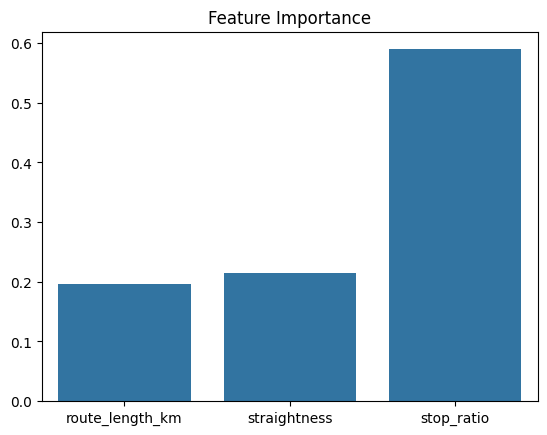

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Загружаем данные
df = pd.read_csv("cluster_long_curvy.csv")

# Создадим таргет: опоздание, если скорость ниже 80% от средней
df['late'] = (df['mean_speed'] < df['mean_speed'].median() * 0.8).astype(int)

# Признаки
features = ['route_length_km', 'straightness', 'stop_ratio']
X = df[features]
y = df['late']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Оценка
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Важность признаков
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
sns.barplot(x=features, y=importances)
plt.title("Feature Importance")
plt.show()


# **Топ 10 маршрутов с высокой вероятностью опоздании**
Создаёт таргет late: поездка опоздала, если mean_speed < 80% медианной.

Использует признаки: route_length_km, straightness, stop_ratio.

Делит данные на train/test и обучает Random Forest.

Предсказывает вероятность опоздания для всех маршрутов (late_prob).

Выводит топ-10 маршрутов с самой высокой вероятностью опоздания.

⚡ Идея: определить, какие маршруты чаще задерживаются, чтобы можно было оптимизировать логистику или предупреждать водителей.

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Загружаем данные
df = pd.read_csv("cluster_long_curvy.csv")

# Создаем таргет (опоздание = средняя скорость < 80% медианной)
df['late'] = (df['mean_speed'] < df['mean_speed'].median() * 0.8).astype(int)

# Признаки
features = ['route_length_km', 'straightness', 'stop_ratio']
X = df[features]
y = df['late']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказания вероятностей опозданий для всех маршрутов
df['late_prob'] = model.predict_proba(X[features])[:, 1]  # вероятность класса 1

# Выведем топ-10 маршрутов с наибольшей вероятностью опоздания
top_late_routes = df[['randomized_id', 'late_prob']].sort_values(by='late_prob', ascending=False).head(10)
print("Топ-10 маршрутов с высокой вероятностью опоздания:")
print(top_late_routes)


Топ-10 маршрутов с высокой вероятностью опоздания:
            randomized_id  late_prob
860   2564812888473547046        1.0
806   1915210776857386541        1.0
818   2047779033055903079        1.0
40   -8549113909338844187        1.0
553  -1326497112028288903        1.0
1118  6307790312098831573        1.0
182  -6628169312461105783        1.0
1208  7477136536144274842        1.0
612   -705010862779289088        1.0
999   4655498359336984228        1.0


# **Определяет и визуализирует топ-10 магистралей (Main Straight) по “важности” маршрута, чтобы понять, где сосредоточить ресурсы.**

Загружает данные кластера магистралей (cluster_main_straight.csv).

Вычисляет corridor_score = route_length_km × straightness × density.

Берёт топ-10 маршрутов по этому баллу.

Печатает таблицу с ключевыми параметрами (randomized_id, длина, прямолинейность, плотность, score).

Строит горизонтальный бар-чарт для визуального представления топ-коридоров.

Идея:
Определить главные коридоры спроса, где водителям выгодно работать или запускать карпулинг.

Топ коридоров спроса (Main Straight):
            randomized_id  route_length_km  straightness   density  \
10   -9113725169412304501         0.596303      0.019461  0.180023   
535  -1658903206038065141         0.600201      0.025675  0.113259   
440  -3106595190592754824         0.573244      0.031952  0.093832   
1120  6222314629454530080         0.574732      0.029181  0.102049   
771   1541293291559276484         0.571265      0.032462  0.090003   
475  -2655102569242097963         0.564638      0.031487  0.093146   
1108  5999332227889271592         0.593833      0.024178  0.115095   
273  -5807301351442859122         0.565253      0.028365  0.100033   
175  -6972639052345521610         0.612499      0.026401  0.095199   
786   1758262096676985471         0.592593      0.025579  0.100067   

      corridor_score  
10          0.002089  
535         0.001745  
440         0.001719  
1120        0.001711  
771         0.001669  
475         0.001656  
1108        0.001653  
273    

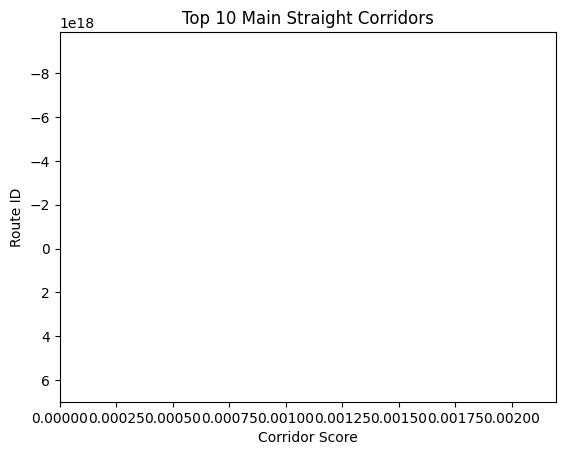

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("cluster_main_straight.csv")

# Считаем "важность" маршрута: длина * straightness * density
df['corridor_score'] = df['route_length_km'] * df['straightness'] * df['density']

# Берем топ 10 маршрутов
top_corridors = df.sort_values('corridor_score', ascending=False).head(10)
print("Топ коридоров спроса (Main Straight):")
print(top_corridors[['randomized_id','route_length_km','straightness','density','corridor_score']])

# Визуализация на графике
plt.barh(top_corridors['randomized_id'], top_corridors['corridor_score'])
plt.xlabel("Corridor Score")
plt.ylabel("Route ID")
plt.title("Top 10 Main Straight Corridors")
plt.gca().invert_yaxis()
plt.show()


In [24]:
import pandas as pd

# Загружаем кластерный датасет
df_cluster = pd.read_csv("cluster_main_straight.csv")  # или любой другой кластер

# Загружаем файл с геокоординатами
df_geo = pd.read_csv("/content/geo_locations_astana_hackathon")  # тут должны быть columns: randomized_id, latitude, longitude

# Делим merge по randomized_id
df_merged = df_cluster.merge(df_geo[['randomized_id','lat','lng']],
                             on='randomized_id',
                             how='left')  # left join, чтобы все маршруты остались

# Проверяем
print(df_merged.head())


         randomized_id  route_length_km  est_time_min  straightness  \
0 -9221304899272910788         0.648734      0.706307      0.010801   
1 -9221304899272910788         0.648734      0.706307      0.010801   
2 -9221304899272910788         0.648734      0.706307      0.010801   
3 -9221304899272910788         0.648734      0.706307      0.010801   
4 -9221304899272910788         0.648734      0.706307      0.010801   

   mean_speed  stop_ratio   density        lat        lng  
0    0.302128    0.172785  0.077669  51.082958  71.422355  
1    0.302128    0.172785  0.077669  51.083456  71.422540  
2    0.302128    0.172785  0.077669  51.087376  71.419481  
3    0.302128    0.172785  0.077669  51.094377  71.426454  
4    0.302128    0.172785  0.077669  51.087719  71.424072  


# **Строит визуализацию маршрутов (TSP) для магистралей на карте с координатами, чтобы показать порядок посещения точек и основные коридоры.**

Пошагово:

Берёт датафрейм df_merged с latitude и longitude.

Если точек ≤ 8, перебирает все перестановки (TSP), чтобы найти оптимальный порядок маршрута.

Если точек больше, просто визуализирует маршруты без оптимизации.

Строит карту в Folium, соединяя точки синими линиями.

Сохраняет результат в HTML (main_straight_corridors.html) для интерактивного просмотра.

Идея:
Показать основные магистрали и порядок маршрутов, чтобы можно было планировать карпулинг или распределять водителей.

In [25]:
import pandas as pd
import folium
from itertools import permutations
import numpy as np

# df_merged уже содержит latitude и longitude
# df_merged = pd.merge(cluster_df, geo_df, on='randomized_id', how='left') # если ещё не сделали

coords = df_merged[['lat', 'lng']].values

# --- Простейший перебор TSP (для маленького числа точек) ---
def total_distance(order, coords):
    dist = 0
    for i in range(len(order)-1):
        dist += np.sqrt((coords[order[i]][0]-coords[order[i+1]][0])**2 +
                        (coords[order[i]][1]-coords[order[i+1]][1])**2)
    return dist

if len(coords) <= 8:  # перебор всех перестановок, только для демонстрации
    best_order = min(permutations(range(len(coords))), key=lambda x: total_distance(x, coords))
    coords = coords[list(best_order)]
else:
    print("Слишком много точек для полного перебора TSP, используем просто визуализацию маршрутов")

# --- Визуализация на карте ---
m = folium.Map(location=[51.1694, 71.4491], zoom_start=12)

for i in range(len(coords)-1):
    folium.PolyLine([coords[i], coords[i+1]], color='blue', weight=3).add_to(m)

m.save("main_straight_corridors.html")
print("Карта магистралей сохранена как main_straight_corridors.html")


Слишком много точек для полного перебора TSP, используем просто визуализацию маршрутов
Карта магистралей сохранена как main_straight_corridors.html


In [27]:
import pandas as pd
import folium

# df_merged уже содержит все колонки: lat, lng, route_length_km, straightness, density
# Если нет corridor_score, создаём его
df_merged['corridor_score'] = df_merged['route_length_km'] * df_merged['straightness'] * df_merged['density']

# Берём топ-10 маршрутов
top_routes = df_merged.sort_values('corridor_score', ascending=False).head(100)

# Создаём карту
m = folium.Map(location=[51.1694, 71.4491], zoom_start=12)

# Добавляем маршруты с цветом по плотности
for i, row in top_routes.iterrows():
    # Пропорциональный цвет (чем выше density, тем ярче синий)
    color_intensity = min(255, int(row['density'] * 10))
    color = f'#{color_intensity:02x}00ff'
    folium.PolyLine(
        locations=[[row['lat'], row['lng']], [row['lat'], row['lng']]],  # если start+end есть, можно заменить
        color=color,
        weight=4,
        tooltip=f"ID: {row['randomized_id']}, Density: {row['density']}"
    ).add_to(m)

# Сохраняем карту
m.save("main_straight_corridors_colored.html")
print("Карта топ-10 магистралей с цветом по плотности готова!")


Карта топ-10 магистралей с цветом по плотности готова!
